### Задание 7 (2 балла)
Вам предлагается реализовать алгоритм аппроксимации функции синус с помощью метода [МНК](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2)

$$f(x)=sin(x), x \in [-180, 180]$$

* Вам необходимо будет аппроксимировать функцию на этом отрезке.
* Сформировать обучающее и тестовое множества самостоятельно.
* Использовать готовую реализацию из numpy в пунктах 1 и 2 - нельзя.
* Оценку времени выполнять из 10 запусков.
* При построении графиков, вам необходимо учитывать все 10 запусков (отразить дисперсию, "график с трубой")
* Кроссвалидацию делать необязательно
* Помните про радианы и градусы


In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### 0. Создайте данные для решения задачи (0,1)

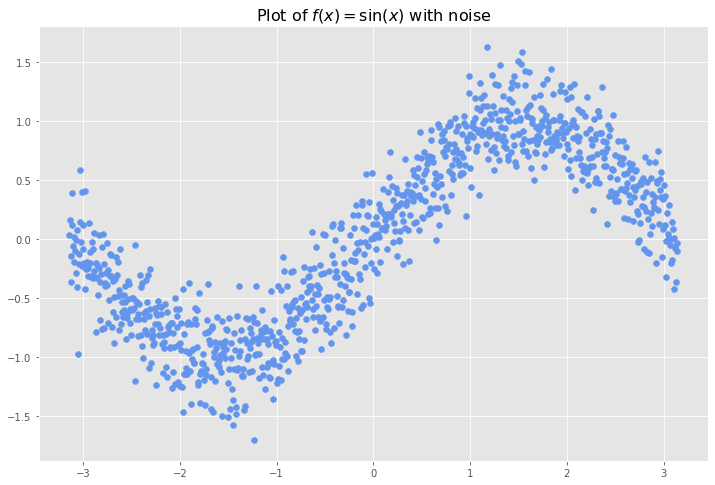

In [2]:
num_points = 1000
xs = np.linspace(-np.pi, np.pi, num=num_points)
ys = np.sin(xs) + np.random.randn(num_points) / 4

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, marker='o', color='cornflowerblue')
plt.title(r'Plot of $f(x) = \sin(x)$ with noise', fontsize=16)
plt.show()

#### 1. Реализуйте МНК с помощью numpy (0,2)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

In [3]:
def estimate_coef(x, y, with_b=True):  
    n = np.size(x) 
    
    if (with_b):
        x_mean, y_mean = np.mean(x), np.mean(y) 

        sum_squares_xy = np.sum(y * x) - n * y_mean * x_mean 
        sum_squares_xx = np.sum(x * x) - n * x_mean * x_mean 
        sum_squares_yy = np.sum(y * y) - n * y_mean * y_mean

        k = sum_squares_xy / sum_squares_xx 
        b = y_mean - k * x_mean 
        sigma_k = np.sqrt(1. / (n - 2) * ((sum_squares_yy / sum_squares_xx) - k ** 2))
        sigma_b = sigma_k * np.sqrt(np.mean(x ** 2))
        return (k, b, sigma_k, sigma_b) 
    else: 
        k = np.sum(y * x) / np.sum(x * x)
        sigma_k = np.sqrt(1. / (n - 1) * ((np.sum(y * y) / np.sum(x * x)) - k ** 2))
        return (k, sigma_k)

In [4]:
intercept, slope, sigma_intercept, sigma_slope = estimate_coef(xs, ys)
y_pred = intercept * xs + slope

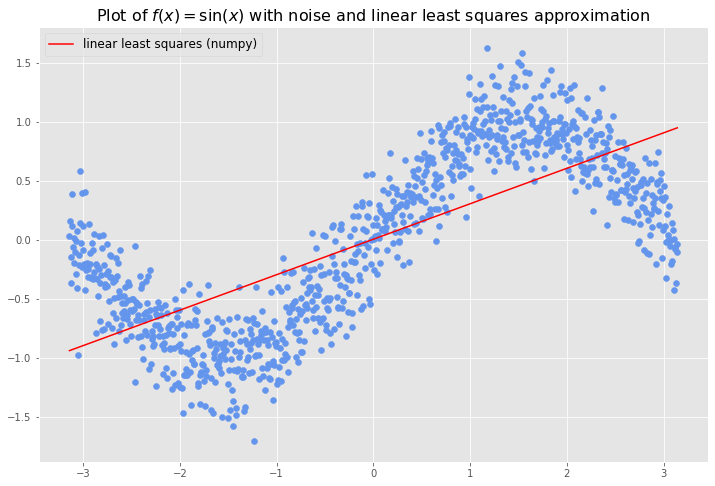

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, marker='o', color='cornflowerblue')
plt.plot(xs, y_pred, color='red', label='linear least squares (numpy)')
plt.title(r'Plot of $f(x) = \sin(x)$ with noise and linear least squares approximation', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.show()

#### 2. Реализуйте МНК с помощью numpy и cdef (0,3)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

In [6]:
%load_ext Cython

In [7]:
%%cython --annotate
cimport numpy as np
from numpy import sqrt, mean
from numpy import sum as np_sum

def estimate_coef_cython(np.ndarray x, np.ndarray y, with_b=True):  
    cdef int n = len(x)
    cdef double k, b, sigma_k, sigma_b, sum_squares_xx, sum_squares_xy, sum_squares_yy
    
    if (with_b):
        x_mean, y_mean = mean(x), mean(y) 

        sum_squares_xy = np_sum(y * x) - n * y_mean * x_mean 
        sum_squares_xx = np_sum(x * x) - n * x_mean * x_mean 
        sum_squares_yy = np_sum(y * y) - n * y_mean * y_mean

        k = sum_squares_xy / sum_squares_xx 
        b = y_mean - k * x_mean 
        sigma_k = sqrt(1. / (n - 2) * ((sum_squares_yy / sum_squares_xx) - k ** 2))
        sigma_b = sigma_k * sqrt(mean(x ** 2))
        return (k, b, sigma_k, sigma_b) 
    else: 
        k = np_sum(y * x) / np_sum(x * x)
        sigma_k = sqrt(1. / (n - 1) * ((np_sum(y * y) / np_sum(x * x)) - k ** 2))
        return (k, sigma_k)

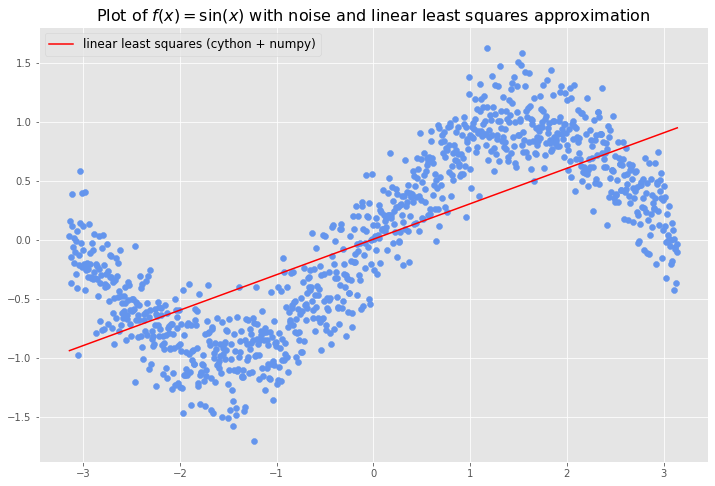

In [8]:
%%cython
from __main__ import estimate_coef_cython
from __main__ import xs, ys, plt

intercept, slope, sigma_intercept, sigma_slope = estimate_coef_cython(xs, ys)
y_pred = intercept * xs + slope

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, marker='o', color='cornflowerblue')
plt.plot(xs, y_pred, color='red', label='linear least squares (cython + numpy)')
plt.title(r'Plot of $f(x) = \sin(x)$ with noise and linear least squares approximation', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.show()

#### 3. Реализуйте МНК с помощью c extensions (0,4)
Реализуйте и протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию

#### 4. Сравните время работы (0,1)
Сравните время работы реализаций из пунктов "1. Реализуйте МНК с помощью numpy", "2. Реализуйте МНК с помощью numpy и cdef" и "3. Реализуйте МНК с помощью c extensions"

In [9]:
import timeit

py_time = timeit.repeat('estimate_coef(xs, ys)', setup='from __main__ import estimate_coef, xs, ys',
                        repeat=10, number=10000)
cy_time = timeit.repeat('estimate_coef_cython(xs, ys)', setup='from __main__ import estimate_coef_cython, xs, ys',
                        repeat=10, number=10000)

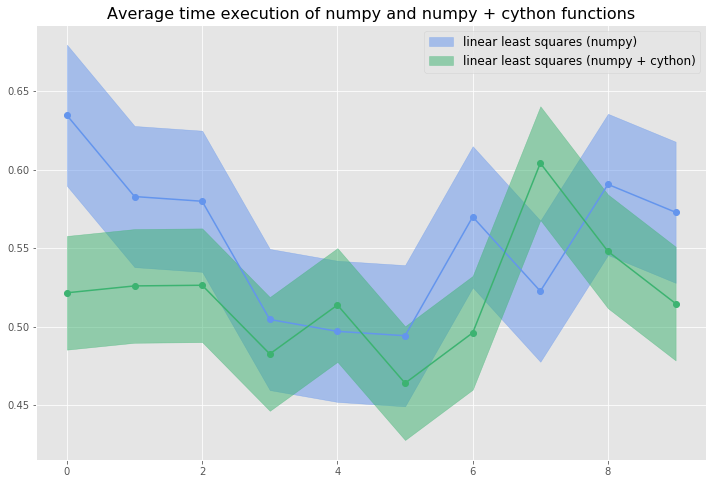

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(10), py_time, marker='o', color='cornflowerblue')
plt.fill_between(np.arange(10), py_time - np.std(py_time), py_time + np.std(py_time),
                 color='cornflowerblue', alpha=0.5, label='linear least squares (numpy)')
plt.plot(np.arange(10), cy_time, marker='o', color='mediumseagreen')
plt.fill_between(np.arange(10), cy_time - np.std(cy_time), cy_time + np.std(cy_time),
                 color='mediumseagreen', alpha=0.5, label='linear least squares (numpy + cython)')
plt.title(r'Average time execution of numpy and numpy + cython functions', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.show()

#### 5. Сделайте выводы по полученным оценкам времени (0,3):
В частности, ответить на вопросы:
1. Увеличилось ли время при использовании cdef в сравнении с numpy? - Почему? **(0,1)**
2. Как влияет c extensions на производительность? **(0,1)**
3. Сравните c extensions и вашу numpy реализацию. **(0,1)**

1. Время при использовании cdef не увеличилось, скорее можно утверждать, что время выполнения в среднем уменьшилось, но совершенно незначительно. Это могло происходить из-за того, что была добавлена статическая типизация.

#### 6. Сделайте профилирование (0,4)
1. Сделайте профилирование реализации из пункта 1, можно ли как-то ускорить? **(0,2)**
1. Сделайте профилирование реализации из пункта 2, можно ли как-то ускорить? **(0,2)**

In [11]:
import cProfile, pstats, io

def profile(fnc):
    
    """A decorator that uses cProfile to profile a function"""
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable()
        retval = fnc(*args, **kwargs)
        pr.disable()
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        return retval

    return inner

In [12]:
@profile
def estimate_coef(x, y, with_b=True):  
    n = np.size(x) 
    
    if (with_b):
        x_mean, y_mean = np.mean(x), np.mean(y) 

        sum_squares_xy = np.sum(y * x) - n * y_mean * x_mean 
        sum_squares_xx = np.sum(x * x) - n * x_mean * x_mean 
        sum_squares_yy = np.sum(y * y) - n * y_mean * y_mean

        k = sum_squares_xy / sum_squares_xx 
        b = y_mean - k * x_mean 
        sigma_k = np.sqrt(1. / (n - 2) * ((sum_squares_yy / sum_squares_xx) - k ** 2))
        sigma_b = sigma_k * np.sqrt(np.mean(x ** 2))
        return (k, b, sigma_k, sigma_b) 
    else: 
        k = np.sum(y * x) / np.sum(x * x)
        sigma_k = np.sqrt(1. / (n - 1) * ((np.sum(y * y) / np.sum(x * x)) - k ** 2))
        return (k, sigma_k)

In [13]:
k, b, sigma_k, sigma_b = estimate_coef(xs, ys)

         75 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <ipython-input-12-d7a2435cba9b>:1(estimate_coef)
        7    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(mean)
        3    0.000    0.000    0.000    0.000 /home/ilya/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3231(mean)
        3    0.000    0.000    0.000    0.000 /home/ilya/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:134(_mean)
        6    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(sum)
        3    0.000    0.000    0.000    0.000 /home/ilya/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.p

In [14]:
%%cython
cimport numpy as np
from numpy import sqrt, mean
from numpy import sum as np_sum
from __main__ import profile, xs, ys

@profile
def estimate_coef_cython(np.ndarray x, np.ndarray y, with_b=True):  
    cdef int n = len(x)
    cdef double k, b, sigma_k, sigma_b, sum_squares_xx, sum_squares_xy, sum_squares_yy
    
    if (with_b):
        x_mean, y_mean = mean(x), mean(y) 

        sum_squares_xy = np_sum(y * x) - n * y_mean * x_mean 
        sum_squares_xx = np_sum(x * x) - n * x_mean * x_mean 
        sum_squares_yy = np_sum(y * y) - n * y_mean * y_mean

        k = sum_squares_xy / sum_squares_xx 
        b = y_mean - k * x_mean 
        sigma_k = sqrt(1. / (n - 2) * ((sum_squares_yy / sum_squares_xx) - k ** 2))
        sigma_b = sigma_k * sqrt(mean(x ** 2))
        return (k, b, sigma_k, sigma_b) 
    else: 
        k = np_sum(y * x) / np_sum(x * x)
        sigma_k = sqrt(1. / (n - 1) * ((np_sum(y * y) / np_sum(x * x)) - k ** 2))
        return (k, sigma_k)
    
k, b, sigma_k, sigma_b = estimate_coef_cython(xs, ys)

         71 function calls in 0.000 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 {_cython_magic_58e701a11d1262be9ed30c50e0fdb4d7.estimate_coef_cython}
        6    0.000    0.000    0.000    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(mean)
        3    0.000    0.000    0.000    0.000 /home/ilya/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3231(mean)
        3    0.000    0.000    0.000    0.000 /home/ilya/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:134(_mean)
        6    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(sum)
        3    0.000    0.000    0.000    0.000 /home/ilya/anaconda3/lib/python3.7/site-packages/num

Так как функции сами по себе работают быстро, то сложно найти место, где их можно было бы улучшить.

#### 7. Используйте готовую реализацию МНК из numpy / scipy (0,1)
Протестируйте, постройте график, показывающий реальное значение функции и аппроксимацию.

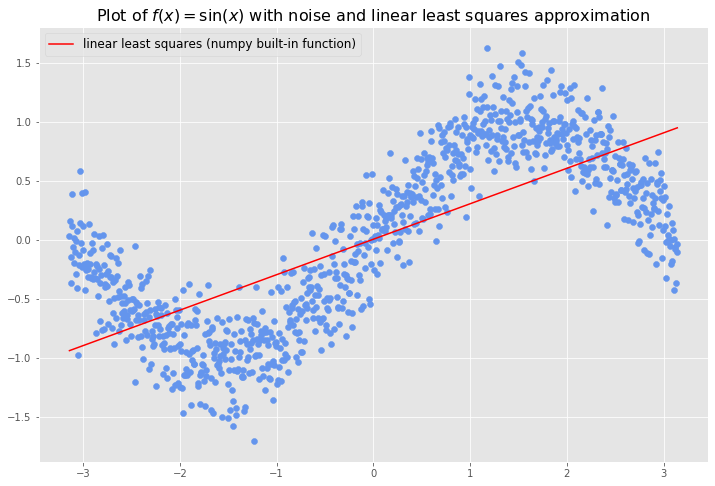

In [15]:
coeficients = np.polyfit(xs, ys, deg=1)
y_pred = coeficients[0] * xs + coeficients[1]

plt.figure(figsize=(12, 8))
plt.scatter(xs, ys, marker='o', color='cornflowerblue')
plt.plot(xs, y_pred, color='red', label='linear least squares (numpy built-in function)')
plt.title(r'Plot of $f(x) = \sin(x)$ with noise and linear least squares approximation', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.show()

#### 8. Выводы (0,1)
Резюмируйте и сделайте выводы относительно проведенных экспериментов

Разобраться с C extensions не вышло на текущий момент, поэтому пока про эту часть не могу сделать выводов. Работа numpy реализации и numpy + cdef реализации схожи по времени работы. Реализация функции получилась довольно простая, numpy справляется со всеми операциями быстро, поэтому по результатам профилирования кода не получается выделить те его части, которые можно было бы изменить.